# La théorie du bien-être social


Le problème présenté ici, connu sous l'acronyme **MARA** (Multiagent Resource allocation), rentre dans le cadre de l'affectation de ressources à un certain nombre d'agents. On considère un ensemble de ressources et un ensemble d'agents à qui l'on doit distribuer ces ressources. Les resources considérées ici sont continues, indivisibles et non-partageables. Chaque agent étant autonome, il n'accorde pas la même importance aux différentes ressources que ses congénères. Pour mesurer la satisfaction d'un agent lors de la possession d'un certain nombre de ressources on utilise ici une fonction d'utilité qui, pour chaque ressource, indique la valeur que l'agent lui accorde. D'autres considérations pourraient bien-sûr être prises en compte, nous restons ici dans un cadre simple. Le bien-être individuel d'un agent est évalué par la somme des utilités qu'il accorde aux ressources qu'il possède (on dit que les ressources sont k-additives avec k=1, car dans des cas complexes on pourrait considérer que posséder n ressources vaut plus que la valeur de chacune d'entre-elles).
Mais la collectivité doit aussi s'accorder sur une mesure de bien-être. Pour mesurer le bien-être social, il existe 4 grandes méthodes classiques:

- Utilitaire : maximiser la somme des utilités de chaque agent
- Egalitaire : maximiser le minimum
- Elitiste : maximiser le maximum
- ressource de Nash : maximiser le ressource

Le problème consiste alors à trouver comment affecter l'ensemble des ressources aux différents agents de manière à maximiser le bien-être social choisi.

Cette feuille montre comment, à l'aide d'une approche comportementale, il est possible de s'approcher voire de calculer l'optimum social.

### Comment coder ressources et fonctions d'utilité

Afin de pouvoir jouer sur les nombres de ressources et/ou d'agents, nous générerons aléatoirement des noms de ressources afin de pouvoir en avoir autant que l'on souhaite.  Pour la fonction d'utilité, on utilisera un dictionnaire Python, donc les clés sont les ressources potentielles et les valeurs le poids que l'agent accorde à cette clé. Pour ces valeurs on prendra un entier naturel (donc sans le zero, qui évidemment pose problème lors d'un produit de Nash). Par convention, plus il sera important, plus l'agent accordera de la valeur à cet article.


In [1]:
import numpy as np
import pandas as pd # mainly for results
import random       # mainly for choice et randrange
# import string     # mainly for ascii_uppercase
import functools    # mainly for reduce
import copy         # mainly for deepcopy 

nb_resources =10                        # nb de ressources souhaités
valeurs = list(range(1,20))  # intervalle de valuation de chaque ressource

def genere_nom():
    return ''.join(random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ') for _ in range(5))
   
# Generer une liste de ressources
ressources = [genere_nom() for _ in range(nb_resources)]
print("Un ensemble de ressources \t", ressources)

# Creer une fonction d'utilité avec des valeurs aléatoires
u = {r : random.choice(valeurs) for r in ressources}
print("Une fonction d'utilité\t" , u)

Un ensemble de ressources 	 ['XUJSC', 'AXCAR', 'VPJEC', 'JNTOL', 'VOMHG', 'PSXEL', 'NGPQP', 'IWBWX', 'QTNWY', 'QFQPW']
Une fonction d'utilité	 {'XUJSC': 8, 'AXCAR': 2, 'VPJEC': 12, 'JNTOL': 11, 'VOMHG': 7, 'PSXEL': 9, 'NGPQP': 7, 'IWBWX': 6, 'QTNWY': 19, 'QFQPW': 4}


# On passe aux agents
Un agent est défini avec le `bag` de ressources qu'il possède et une fonction d'utilité `fUtil` lui permettant de l'évaluer.
Lors de sa création, la fonction d'évalution de l'agent est définie aléatoirement. Le bag est initialement vide. La méthode `welfare` permet de connaître le bien-être individuel de l'agent, ou en d'autres termes, comment l'agent évalue son bag.

In [2]:
class Agent:
    def __init__(self,name) :
        self.name=name
        self.fUtil = {r : random.choice(valeurs) for r in ressources}
        self.bag = []
    def __str__(self) :
        return "agent "+str(self.name)+"  "+ str(len(self.bag)) + " resources. Individual welfare "+ str(self.welfare())
    def welfare(self):
        return sum([self.fUtil.get(r) for r in self.bag]) 
        

Quelques manipulations basiques sur un agent pour s'entrainer ;-)

In [3]:
a=Agent("ag")
a.bag=random.sample(ressources,5) # choices : avec remplacement ; sample : sans remplacement

# le bag de l'agent a
print("Bag \t\t", a.bag)                              # ou sorted(a.bag)

# la fonction d'utilité de l'agent a
print("fUtil \t\t", a.fUtil)                        # ou dict(sorted(a.fUtil.items()))

# le bien-être de l'agent a
print("welfare \t", a.welfare())

# le bag avec ses valeurs
bv = [ (r,a.fUtil.get(r)) for r in a.bag]
print("bag valué \t" , bv )

# le bag valué , trié par ordre croissant des valeurs
print("bag valué trié \t", sorted(bv, key=lambda x: x[1]) )

# les ressources, triées par valuation (la premier est celle dont on se débarrasse le plus facilement
print("ressourc triées\t",  [r for r,_ in sorted(bv, key=lambda x: x[1])]    )

Bag 		 ['VOMHG', 'QTNWY', 'QFQPW', 'IWBWX', 'XUJSC']
fUtil 		 {'XUJSC': 4, 'AXCAR': 11, 'VPJEC': 17, 'JNTOL': 18, 'VOMHG': 11, 'PSXEL': 19, 'NGPQP': 15, 'IWBWX': 5, 'QTNWY': 9, 'QFQPW': 16}
welfare 	 45
bag valué 	 [('VOMHG', 11), ('QTNWY', 9), ('QFQPW', 16), ('IWBWX', 5), ('XUJSC', 4)]
bag valué trié 	 [('XUJSC', 4), ('IWBWX', 5), ('QTNWY', 9), ('VOMHG', 11), ('QFQPW', 16)]
ressourc triées	 ['XUJSC', 'IWBWX', 'QTNWY', 'VOMHG', 'QFQPW']


On peut maintenant créer autant d'agents que l'on souhaite, leur affecter des ressources et calculer leur bien-être individuel

In [4]:
# creer 5 agents
agentList = [Agent("ag"+str(i)) for i in range(5) ]
 
# distribuer les ressources aléatoirement
for i in range(len(ressources)) :
    random.choice(agentList).bag.append(ressources[i])

# afficher les agents
for a in agentList: print(a)

agent ag0  3 resources. Individual welfare 39
agent ag1  2 resources. Individual welfare 13
agent ag2  3 resources. Individual welfare 33
agent ag3  0 resources. Individual welfare 0
agent ag4  2 resources. Individual welfare 31


# Approche centralisée
Maintenant que les agents ont un `bag` rempli, il est maintenant possible de calculer le bien-être de cette société d'agents.
Le calcul du bien-être social consiste à appliquer une opération spécifique (selon la fonction de bien-être souhaitée) à la valuation du bag de chaque agent. Pour le bien-être-social utilitaire c'est par exemple une somme.

| nom | fn à maximiser | Caractéristique |
| -----| ----|--- |
| utilitaire | somme | équilibre global, sans tenir compte des bien-être individuels |
| égalitaire | min | permet de satisfaire un minimum de désir pour tous les agents 
| élististe | max | on donne tout à son "champion" |
| Nash | produit | à la fois augmentation de l’utilité globale mais aussi diminution des inégalités |


In [5]:
print('Utilitarian Social Welfare\t', functools.reduce(lambda a, b: sum([a,b]) , [a.welfare() for a in agentList]) )
print('Egalitarian Social Welfare\t', functools.reduce(lambda a, b: min([a,b]) , [a.welfare() for a in agentList]) )
print('Elitist Social Welfare\t\t',   functools.reduce(lambda a, b: max([a,b]) , [a.welfare() for a in agentList]) )
print('Nash Social Welfare\t\t', functools.reduce(lambda a, b: np.prod([a,b]) , [a.welfare() for a in agentList]) )


Utilitarian Social Welfare	 116
Egalitarian Social Welfare	 0
Elitist Social Welfare		 39
Nash Social Welfare		 0


### Notion d'optimal social

Parmi toutes les affectations possibles de différentes ressources, certaines fournissent la valeur maximale possible à la fonction de bien-être social. Pour certains bien-être sociaux cette affectation est facile à calculer (elististe, utilitaire) , pour d'autres c'est beaucoup plus compliqué. De plus, on considère ici qu'une "main invisible" (clin d'oeil à [Adam Smith](https://fr.wikipedia.org/wiki/Main_invisible)) distribue les ressources comme par magie. Si on souhaite prendre en compte les relations sociales entre les agents, cela devient compliqué même pour les fonctions d'utilité les plus simples.

##### Solution optimale pour le bien-être social élitiste
Le bien-être social **élitiste** consiste à **maximiser la richesse du plus riche** des agents (tout donner à son "champion" en quelque sorte). Quand les utilités sont 1-additives, calculer cet optimal est facile puisqu'il suffit de donner toutes les ressources à l'agents qui valorise le mieux la totalité des ressources.
La "main invisible" affecte tour à tour tous les produis à chaque agent, et regarde qui est au bien-être maximum (on pourrait imaginer faire la somme des valuations de la fonction d'utilité sans affecter les ressources, mais cela ne fonctionnerait que si une ressource n'apparaît qu'une et une seule fois).

In [6]:
# on affecte toutes les ressources à tous les agents
for a in agentList:
    a.bag = ressources.copy()

# On recherche la plus forte évaluation
index = np.argmax([a.welfare() for a in agentList])
m = agentList[index].welfare()

print("Elitiste. Valeur optimale : ", m,". Obtenue en donnant tout à l'agent ", agentList[index].name)

Elitiste. Valeur optimale :  131 . Obtenue en donnant tout à l'agent  ag2


##### Solution optimale pour le bien-être social utilitaire
Le bien-être social **utilitaire** consiste à **maximiser la somme** des richesses de tous les agents. Calculer cet optimal est facile puisqu'il suffit de donner chaque ressource à l'agent qui la valorise le mieux.

In [7]:
# on réinitialise les bags
for a in agentList :
        a.bag=[]

# on affecte les ressources 1 par 1 à l'agent qui la valorise le mieux               
for r in ressources :
        index = np.argmax([a.fUtil.get(r)  for a in agentList])
        ag = agentList[index]
        ag.bag.append(r)

# On fait la somme des évaluation
s = sum([a.welfare() for a in agentList])

print("Utilitaire. Valeur optimale : ", s ," obtenue avec les affectations ")
for a in agentList :
        print(a, a.bag)   

Utilitaire. Valeur optimale :  172  obtenue avec les affectations 
agent ag0  3 resources. Individual welfare 54 ['XUJSC', 'VOMHG', 'QFQPW']
agent ag1  1 resources. Individual welfare 19 ['JNTOL']
agent ag2  3 resources. Individual welfare 50 ['PSXEL', 'NGPQP', 'IWBWX']
agent ag3  2 resources. Individual welfare 35 ['AXCAR', 'QTNWY']
agent ag4  1 resources. Individual welfare 14 ['VPJEC']


##### Solution optimale pour les bien-êtres égalitaires ou nash
Cette fois il n'y a pas de solution simple, même pour une "main invisible". Il faudrait tester toutes les allocations possibles. Avec `n` agents et `r` ressources il existe `n^r` affectations possibles (si on a 10 agents et 100 ressources cela fait 10^100 tests, ce qui est hors de portée des ordinateurs actuels).
On peut alors éventuellement utiliser des méthodes approximatives type _Monte-Carlo_ ou _Algorithme génétique_, mais rien ne garantit l'optimalité du résultat.

Ci-dessous une méthode de _Monte-Carlo_ pour le bien-être de Nash ...

In [8]:
bestWelfare=-1
bestAlloc=[]
for i in range(100000):
    # on réinitialise les bags
    for a in agentList :
        a.bag=[]
    # on affecte les ressources au hasard
    for r in ressources :
        a = random.choice(agentList)
        a.bag.append(r)
    # On compare le résultat à la meilleure situation connue
    p = np.prod([a.welfare() for a in agentList])  # sum,prod,min,max
    if (p > bestWelfare):
        bestWelfare=p
        bestAlloc = {a.name:a.bag for a in agentList}
        
print("Meilleure allocation",bestWelfare,bestAlloc)

Meilleure allocation 32356870 {'ag0': ['XUJSC', 'VOMHG'], 'ag1': ['VPJEC', 'QFQPW'], 'ag2': ['NGPQP', 'IWBWX'], 'ag3': ['AXCAR', 'QTNWY'], 'ag4': ['JNTOL', 'PSXEL']}


... autre technique, basée sur les permutations de ressources, puisque l'on sait dès le départ que pour Nash il est préférable d'équilibrer les ressources entre les agents.

In [9]:
bestWelfare=-1
bestAlloc=[]
for i in range(100000):
    # on réinitialise les bags
    for a in agentList :
        a.bag=[]
    # on découpe les ressources en paquets égaux
    random.shuffle(ressources)
    distrib = np.array_split(ressources, len(agentList))
    for i in range(len(agentList)) :
        agentList[i].bag = distrib[i]
    # On compare le résultat à la meilleure situation connue
    p = np.prod([a.welfare() for a in agentList])  # sum,prod,min,max
    if (p > bestWelfare):
        bestWelfare=p
        bestAlloc = {a.name:a.bag for a in agentList}
        
print("Meilleure allocation",bestWelfare,bestAlloc)

Meilleure allocation 42393120 {'ag0': array(['XUJSC', 'VOMHG'], dtype='<U5'), 'ag1': array(['JNTOL', 'QFQPW'], dtype='<U5'), 'ag2': array(['NGPQP', 'IWBWX'], dtype='<U5'), 'ag3': array(['QTNWY', 'AXCAR'], dtype='<U5'), 'ag4': array(['PSXEL', 'VPJEC'], dtype='<U5')}


On note ici la différence entre "Individual-based system" and "agent-based system". Jusqu'à présent il y avait bien des agents, chacun avec ses propres connaissances, mais aucun comportement. Il faut la "main invisible" pour résoudre le problème. La majorité du travail algorithmique se fait hors des agents. L'approche "agent-based" est une approche comportementale: tout se passe dans le comportement de l'agent, c'est l'agent qui décide ! Il n'y a plus de "main invisible". Seul un SMA, qui n'est là que pour le strict minimum : donner la parole aux agents.


### Une approche multi-agents

L'approche centralisée présente un certain nombre de défauts :
- Avoir une affectation optimale par cette technique n'est pas toujours possible (voir ci-dessus). 
- Cette technique oblige tous les agents à indiquer à l'organe central de calcul toutes leurs utilités. La garantie d'une certaine privacité est pourtant parfois nécessaire
- La "main invisible" ! L'approche centralisée prend difficilement en compte le fait que les agents ne se connaissent pas forcément tous. Dans la vraie vie, les connaissances des individus dessinent un graphe social 


Nous étudions par la suite une approche comportementale qui permet aux agents d'échanger des ressources pour améliorer le bien-être social. Chaque agent tour à tour peut effectuer certains échanges avec ces accointances fidèles à un type de réseau social. On peut alors voir peu à peu le bien-être social évoluer. L'important maintenant, n'est plus "quel est l'optimum ?", mais "comment on arrive à l'optimum ?".


##### Tout d'abord réalisons le SMA, le réseau social et l'agent ... 
- Cette fois, c'est le SMA qui crée les agents, dans son constructeur.
- Les agents sont initialement créés vides.
- Des méthodes permettent d'affecter aux agents des accointances ou des ressources. Ceci permettra pas la suite de relancer le même SMA soit avec la même affectation de ressources, soit avec le même réseau social, soit les deux.

##### Le réseau social

Comme dans [mas_basics]() on utilisera la librairie [networkx](https://networkx.org/) qui contient de nombreuses fonctions de création de graphes et permet de récupérer avec sa fonction `to_numpy_array` une matrice d'adjacence.

In [10]:
import networkx as nx

nb_nodes = 20
graph = nx.barabasi_albert_graph(nb_nodes, 2)
#graph = nx.complete_graph(nb_nodes)
#graph = nx.erdos_renyi_graph(nb_nodes,0.6)
#graph = nx.cycle_graph(nb_nodes)
#graph = nx.random_regular_graph(3,nb_nodes)
matrix = nx.to_numpy_array(graph, nodelist=range(nb_nodes))

Et pour la représentation graphique ...

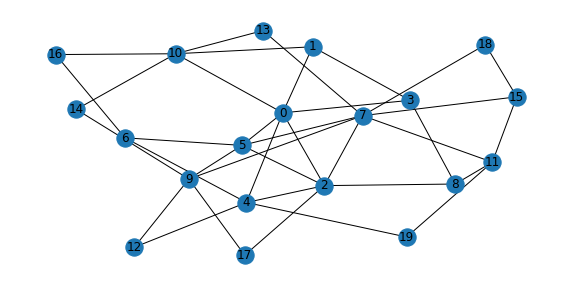

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))    # pour définir la taille de la figure
nx.draw_networkx(graph)
plt.axis('off')
plt.show()

#### L'agent et le SMA
Pour créer un SMA on lui passe simplement le nombre d'agents souhaité. C'est le SMA qui crée les agents. Les méthodes setRessources et setAccointances permettent respectivement d'affecter les agents avec une affectation des ressources aux agents sous forme d'une liste de listes, et une matrice d'adjacence sous forme d'une liste de listes (obtenue facilement à partir d'un graphe networkx).
L'agent est initialement créé sans accointance ni ressource, mais il a déjà sa fonction d'utilité.
Attention : dans le code suivant, recréer un SMA recrée aussi les fonctions d'utilité de chacun !

De nombreux comportements peuvent être mis en place. Sur le nombre de participants à un échange (on en reste ici à 2 : négociation bi-latérale), sur le type d'échange autorisé (des dons, des swaps), ou sur l'ordre dans lequel on propose ces échanges. Même en se focalisant sur le swap il y a encore 3 grandes familles (`swap_kind`):
- les irrationnels : ils échangent n'importe quoi avec n'importe qui, sans rien vérifier
- les rationnels : l'échange ne se fait que si tous les deux y gagnent individuellement. Le don n'a pas de sens pour eux.
- les sociaux : l'échange ne se fait que si la société y gagne. Ce qui se produit pour certains dons, mais pas tous.

Par ailleurs, dans les trois cas précédents il est encore possible de s'y prendre de 2 manières différentes (`behavior_kind`)
- Priorité à la ressource : on prend sa pire ressource et on cherche un ami avec qui on fera l'échange ; si on a fait le tour de ses amis sans succès, alors seulement on change de ressource. 
- Priorité à l'ami : on choisit un ami et on cherche une ressource à lui échanger ; si on a fait le tour de toutes les ressources sans succès avec cet ami, alors seulement on change d'ami.




In [27]:
class SMA:
    def __init__(self, nb_agents, welfare, behavior_kind , swap_kind):
        self.agentList = [Agent(i, self, behavior_kind, swap_kind) for i in range(nb_agents)]
        self.welfare_type=welfare
        self.tick=0
        self.history=[]

    def __str__(self) :
        s=""
        for i in range(len(self.agentList)):
            s=s+(self.agentList[i].__str__()+"\n")
        s=s+("Social Welfare : " + str(self.socialWelfare())) 
        return(s)

    def setRessources(self,init_affect) :
        if (len(init_affect) != len(self.agentList)) :
            raise ValueError("Problem of size in setRessources :", len(init_affect), len(agentList))
        for i in range(len(self.agentList)) :
            self.agentList[i].bag=init_affect[i]

    def setAccointances(self,adjacency_matrix) :
        if (len(adjacency_matrix[0]) != len(self.agentList)) :
            raise ValueError("Problem of size in setAccointances :", len(adjacency_matrix[0]) , len(agentList))
        for i in range(len(self.agentList)) :
            self.agentList[i].accointances = np.nonzero(adjacency_matrix[i])[0]

    def run(self, rounds):
        self.tick=0
        self.history=[]
        self.history.append(self.socialWelfare())
        for i in range(0,rounds):
            self.runOnce()
    
    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick)
        print("tick " + str(self.tick) + " ended")
        self.history.append(self.socialWelfare())
        print("Le Welfare actuel est de ", self.socialWelfare())

    def socialWelfare(self):
        if self.welfare_type.upper()=='UTILITARIST':
            return sum([a.welfare() for a in self.agentList])
        elif self.welfare_type.upper()=='EGALITARIST':
            return min([a.welfare() for a in self.agentList])
        elif self.welfare_type.upper()=='ELISTIST':
            return max([a.welfare() for a in self.agentList])
        elif self.welfare_type.upper()=='NASH':
            return np.prod([a.welfare() for a in self.agentList])
        else :
            raise ValueError("Unknown method in socialWelfare")



# L'agent est le même que précédemment excepté qu'il a maintenant ses propres accointances, sa fonction d'Utilité
# et une méthode de décision avec différents échanges possibles
# Par défaut il n'a ni ressources ni accointances
class Agent:
    def __init__(self, name, sma, behavior_kind, swap_kind) :
        self.name=name
        self.sma = sma
        self.swap_kind = swap_kind
        self.behavior_kind = behavior_kind
        self.fUtil = {r : random.choice(valeurs) for r in ressources}
        self.bag = []
        self.accointances = []
    def __str__(self) :
        return "agent "+str(self.name)+" Welfare :"+ str(self.welfare())+"\tbag :"+ str(self.bag)
    def welfare(self):
        return sum([self.fUtil.get(r) for r in self.bag])
    def getSortedBag(self):
        bagval = [ (r,self.fUtil.get(r)) for r in self.bag]
        return [r for r,_ in sorted(bagval, key=lambda x: x[1])]

    def gift(self):    
        # choisir une accointance au hasard
        friend = sma.agentList[np.random.choice(self.accointances)]
        # choisir une de ses propres ressources au hasard
        r = np.random.choice(self.bag)
        # donner cette ressource à l'accointance
        self.bag.remove(r)
        friend.bag.append(r)
        print(self.name, "donne la ressource ",r," à l'agent ",friend.name)

    # IRRATIONAL : swap sans aucune contrainte
    def swap1(self):
        # choisir une accointance au hasard
        friend = sma.agentList[np.random.choice(self.accointances)]
        # choisir une de ses propres ressources au hasard
        r = np.random.choice(self.bag)
        # choisir une des ressources de l'autre au hasard
        if len(friend.bag)==0 :
            return
        s = np.random.choice(friend.bag)
        # echanger les ressources
        self.bag.remove(r)
        friend.bag.remove(s)
        friend.bag.append(r)
        self.bag.append(s)
        print(self.name, "echange ",r," contre ",s, " avec ",friend.name)
    
    # PRIORITE RESSOURCE : on choisit une ressource et on teste tous les amis avec
    # trois cas possibles : swap_kind = irrational, rational, social
    def swap2(self) :
        # je propose mes ressources par intérêt décroissant (donc valeur croissante)
        for r in self.getSortedBag() :
            # à chacun de mes amis
            for f in self.accointances :
                friend = sma.agentList[f]
                for s in  friend.bag :
                    # on teste si c'est mieux pour les deux
                    # UTILISER sma N'EST PAS TRES "AGENT" , NEANMOINS DES CRITERES LOCAUX EXISTENT
                    actualSocialWelfare = self.sma.socialWelfare()
                    actualMyWelfare = self.welfare()
                    actualFriendWelfare = friend.welfare()
                    self.bag.remove(r)
                    friend.bag.remove(s)
                    friend.bag.append(r)
                    self.bag.append(s)
                    # For irrational (equiv to swap1 ; swap1 is a simplified version)
                    if self.swap_kind.upper()=='IRRATIONAL' :
                        return
                    # For rational welfare
                    if self.swap_kind.upper()=='RATIONAL' and self.welfare() > actualMyWelfare and friend.welfare() > actualFriendWelfare :
                        print(self.name, "echange ",r," contre ",s, " avec ",friend.name)
                        print(self.swap_kind +" : Welfare passe de ",actualSocialWelfare," à ", self.sma.socialWelfare())
                        #self.sma.history.append(self.sma.socialWelfare())
                        return                       
                    # For social welfare
                    if self.swap_kind.upper()=='SOCIAL' and self.sma.socialWelfare() > actualSocialWelfare :
                        print(self.name, "echange ",r," contre ",s, " avec ",friend.name)
                        print(self.swap_kind + " : Welfare passe de ",actualSocialWelfare," à ", self.sma.socialWelfare())
                        #self.sma.history.append(sma.socialWelfare())
                        return
                    # Si les IF ne fonctionnent pas, on remet tout en place
                    self.bag.remove(s)
                    friend.bag.remove(r)
                    friend.bag.append(s)
                    self.bag.append(r)
    
    # PRIORITE FRIEND : on choisit un ami, et on teste toutes les ressources
    # trois cas possibles : swap_kind = irrational, rational, social
    def swap3(self) :
        # je parcours mes amis
        for f in self.accointances :
            friend = sma.agentList[f]
            # puis je propose mes ressources par intérêt décroissant (donc valeur croissante)
            for r in self.getSortedBag() :
                for s in  friend.bag :
                    # on teste si c'est mieux pour les deux
                    # UTILISER sma N'EST PAS TRES "AGENT" , NEANMOINS DES CRITERES LOCAUX EXISTENT
                    actualSocialWelfare = self.sma.socialWelfare()
                    actualMyWelfare = self.welfare()
                    actualFriendWelfare = friend.welfare()
                    self.bag.remove(r)
                    friend.bag.remove(s)
                    friend.bag.append(r)
                    self.bag.append(s)
                    # For irrational (equiv to swap1 ; swap1 is a simplified version)
                    if self.swap_kind.upper()=='IRRATIONAL' :
                        return
                    # For rational welfare
                    if self.swap_kind.upper()=='RATIONAL' and self.welfare() > actualMyWelfare and friend.welfare() > actualFriendWelfare :
                        print(self.name, "echange ",r," contre ",s, " avec ",friend.name)
                        print(self.swap_kind +" : Welfare passe de ",actualSocialWelfare," à ", self.sma.socialWelfare())
                        #self.sma.history.append(self.sma.socialWelfare())
                        return                       
                    # For social welfare
                    if self.swap_kind.upper()=='SOCIAL' and self.sma.socialWelfare() > actualSocialWelfare :
                        print(self.name, "echange ",r," contre ",s, " avec ",friend.name)
                        print(self.swap_kind + " : Welfare passe de ",actualSocialWelfare," à ", self.sma.socialWelfare())
                        #self.sma.history.append(sma.socialWelfare())
                        return
                    # Si les IF ne fonctionnent pas, on remet tout en place
                    self.bag.remove(s)
                    friend.bag.remove(r)
                    friend.bag.append(s)
                    self.bag.append(r)

    def decide(self,tick):
        # pour faire qq chose il faut au moins avoir des ressources et des amis
        if (len(self.accointances)==0 or len(self.bag)==0) :
            return
        # s'écrit avec match-case à partir de python 3.10
        if   self.behavior_kind.upper()=='GIFT'       : self.gift()
        elif self.behavior_kind.upper()=='IRRATIONAL' : self.swap1()
        elif self.behavior_kind.upper()=='RESSOURCE'  : self.swap2()
        elif self.behavior_kind.upper()=='FRIEND'     : self.swap3()
        else : 
            raise ValueError("Impossible behavior in decide")
                

#### Une expérience



In [28]:
nb_agents=5
# une affectation aléatoire
l=[[] for i in range(nb_agents)]
for r in ressources :
    l[random.randrange(nb_agents)].append(r)

# choix du graphe social
graph = nx.complete_graph(nb_nodes)
m = nx.to_numpy_array(graph, nodelist=range(nb_agents))

# L'experience
sma = SMA(nb_agents, welfare='Utilitarist', behavior_kind='friend', swap_kind='social')
sma.setAccointances(m)
sma.setRessources(l)
print(sma)
sma.run(10)

print("Final Social Welfare : ", sma.socialWelfare())
print("Best Social Welfare : ", max(sma.history))
print(sma)

agent 0 Welfare :23	bag :['QTNWY', 'XUJSC']
agent 1 Welfare :43	bag :['IWBWX', 'JNTOL', 'VOMHG']
agent 2 Welfare :37	bag :['AXCAR', 'NGPQP', 'VPJEC']
agent 3 Welfare :22	bag :['PSXEL', 'QFQPW']
agent 4 Welfare :0	bag :[]
Social Welfare : 125
0 echange  XUJSC  contre  VOMHG  avec  1
social : Welfare passe de  125  à  144
2 echange  NGPQP  contre  VOMHG  avec  0
social : Welfare passe de  144  à  149
3 echange  QFQPW  contre  NGPQP  avec  0
social : Welfare passe de  149  à  151
tick 1 ended
Le Welfare actuel est de  151
0 echange  QFQPW  contre  AXCAR  avec  2
social : Welfare passe de  151  à  156
1 echange  JNTOL  contre  QFQPW  avec  2
social : Welfare passe de  156  à  158
2 echange  JNTOL  contre  PSXEL  avec  3
social : Welfare passe de  158  à  159
tick 2 ended
Le Welfare actuel est de  159
tick 3 ended
Le Welfare actuel est de  159
tick 4 ended
Le Welfare actuel est de  159
tick 5 ended
Le Welfare actuel est de  159
tick 6 ended
Le Welfare actuel est de  159
tick 7 ended
Le Welf

#### Tracé de l'évolution du social welfare
Une fois l'expérience réalisée, il est alors possible de tracer l'évolution du social Welfare

[88, 118, 133, 135, 135, 135, 135, 135, 135, 135, 135]


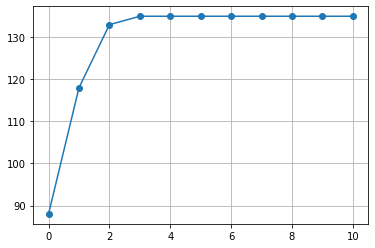

In [18]:
print(sma.history)
plt.plot(sma.history, "-o")
plt.grid()

On peut bien sûr comparer les comportements en jouant sur les paramètres `behavior_kind` et/ou `swap_kind`. Afin de s'assurer que l'on utilise exactement les mêmes afgfectations d'amis et de ressources, on clone le sma à chaque tour.
On prendra garde à la constitution des points de la courbe : si on loggue l'évolution du welfare à chaque changement dans la méthode `swap` par exemple), il n'y aura pas les mêmes valeurs collectées; pour assurer le même nombre de valeurs et donc des courbes comparables, on ne loggue qu'à chaque fin de tick (donc dans `runOnce`)

In [36]:
nb_agents=5
# une affectation aléatoire
l=[[] for i in range(nb_agents)]
for r in ressources :
    l[random.randrange(nb_agents)].append(r)

# choix du graphe social
#graph = nx.erdos_renyi_graph(nb_agents,0.1)
graph = nx.complete_graph(nb_nodes)
m = nx.to_numpy_array(graph, nodelist=range(nb_agents))

# L'experience
sma = SMA(nb_agents, welfare='Utilitarist', behavior_kind='', swap_kind='')
sma.setAccointances(m)
sma.setRessources(l)
data=pd.DataFrame()
for behavior in ['friend','ressource'] :
    for swap in ['irrational','rational','social'] :
        # We work on a copy
        sma2 = copy.deepcopy(sma)
        for a in sma2.agentList:
            a.behavior_kind =  behavior
            a.swap_kind = swap  
        sma2.run(20)
        data[behavior+'_'+swap]=sma2.history

tick 1 ended
Le Welfare actuel est de  97
tick 2 ended
Le Welfare actuel est de  132
tick 3 ended
Le Welfare actuel est de  133
tick 4 ended
Le Welfare actuel est de  125
tick 5 ended
Le Welfare actuel est de  132
tick 6 ended
Le Welfare actuel est de  126
tick 7 ended
Le Welfare actuel est de  130
tick 8 ended
Le Welfare actuel est de  123
tick 9 ended
Le Welfare actuel est de  138
tick 10 ended
Le Welfare actuel est de  130
tick 11 ended
Le Welfare actuel est de  133
tick 12 ended
Le Welfare actuel est de  127
tick 13 ended
Le Welfare actuel est de  123
tick 14 ended
Le Welfare actuel est de  138
tick 15 ended
Le Welfare actuel est de  118
tick 16 ended
Le Welfare actuel est de  135
tick 17 ended
Le Welfare actuel est de  138
tick 18 ended
Le Welfare actuel est de  128
tick 19 ended
Le Welfare actuel est de  124
tick 20 ended
Le Welfare actuel est de  131
0 echange  NGPQP  contre  QFQPW  avec  1
rational : Welfare passe de  90  à  93
1 echange  QFQPW  contre  NGPQP  avec  0
rational 

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

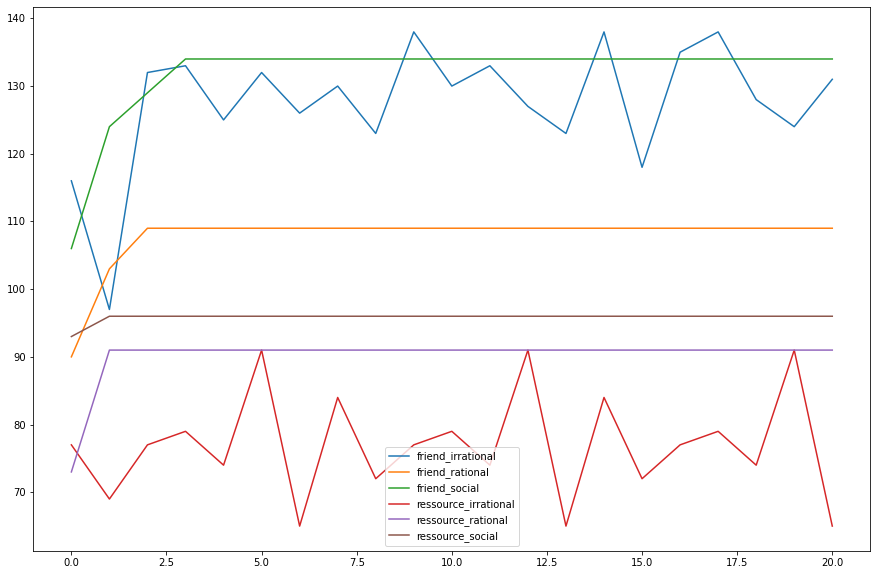

In [42]:
#print(data)
data.plot(figsize=(15,10))

# Exercices

1. Dans le code précédent, le comportementest soit swap soit don. Or le don n'est jamais qu'un swap avec une ressource vide. Comment modifier le swap pour qu'il intègre le don ? Bien évidemment ce don n'a de sens que pour les swap sociaux.
1. Comme le hasard intervient dans chaque expérience (distribution initiale des ressources, graphe s'il n'est pas complet), il est important de pouvoir répérer les mesures afin de moyenner les résultats. 
Tracer un tableau indiquant le nombre de victoires pour les 6 cas précédents répétés 100. 
1. le bien-être social étudié
    - Précédemment, nous avons présenté 4 mesures de bien-être social. Que donne le Leximin ? Le leximin consiste à maximiser dans l'ordre lexicographique les vecteurs des utilités de chaque agent classées du min au max
1. le type de graphe
    - Est-ce que des phénomènes spécifiques se produisent selon la forme du graphe ou le taux de connectivité moyen ?
1. le type d'échange accepté
    - Actuellement il n'y a que des échanges de taille 0 ou 1. Qu'est-ce que cela change d'accepter des échanges de 2 ou 3 ressources en même temps ?
1. Les agents sont pour l'instant tous homogènes. Ils appliquent tous le même comportement. Qu'est-ce que ça donne si la population est hétérogène ?



# Bibliographie
- Moulin, H. (2004). Fair division and collective welfare. MIT press.
- Chevaleyre Y, Endriss U, Lang J, Maudet N (2005) Negotiating over small bundles of resources. In: AAMAS’05, pp 296–302
- Nongaillard, A., & Mathieu, P. (2014). Agent-based reallocation problem on social networks. Group Decision and Negotiation, 23(5), 1067-1083.
- Delahaye, J. P., & Mathieu, P. (2009). La répartition idéale des biens existe-t-elle?. Pour la science, 381, 88-93.
- Ferber J. (1995). Systèmes Multi-Agents, vers une intelligence collective. InterEditions. [en ligne ici](http://www.lirmm.fr/~ferber/publications/LesSMA_Ferber.pdf)

In [ ]:
print('Leximin Social Welfare\t\t', sorted([a.welfare() for a in agentList]) )
 
# 1 if a<b ; -1 if b<a ; 0 if a==b
def leximin(a,b) :
    for i in range(len(a)) :
        if (a[i]>b[i]) :
           return 1
        elif (a[i]<b[i]) :
           return -1
    return 0

x=np.array([1,2,3,4])
y=np.array([1,1,3,4])
leximin(x,y) 